# Setting up a latent function Gaussian Process

Let us start by importing Turing.jl, the library we will use to write our statistical model and our GaussianProcess.jl package. \
The rest of the imports will only be used to generate the data and plot. 

In [77]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using Interpolations
using GaussianProcess

### 1. Make some fake data
This time we will apply a non-linear transformation to our data.

In [161]:
function make_mean(X)
    return @.(exp(-X) + 0.1*log(1+X))
end

function make_non_lin(X)
    return @. exp(-X + X^2)
end

make_non_lin (generic function with 1 method)

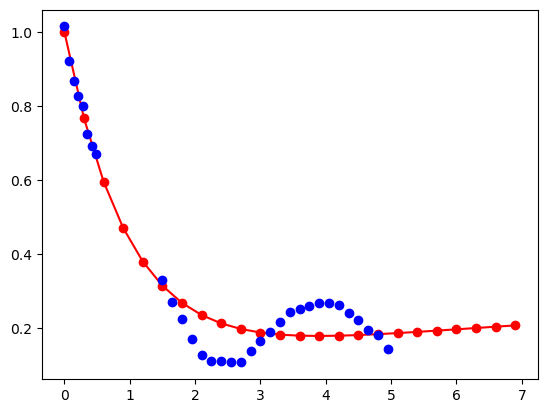

In [162]:
data_1_x = Vector(0:0.07:0.5)
data_2_x = Vector(1.5:0.15:5)
data_x = [data_1_x; data_2_x]
true_nodes = similar(data_x)
true_nodes[1:length(data_1_x), 1] = make_mean(data_1_x) .* (1 .+ randn(length(data_1_x)) .* 0.03)
true_nodes[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = make_mean(data_2_x) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))

gp_x = Vector(0:0.3:7)
plt.errorbar(data_x, true_nodes, fmt="bo")
plt.plot(gp_x, make_mean(gp_x), "ro-");

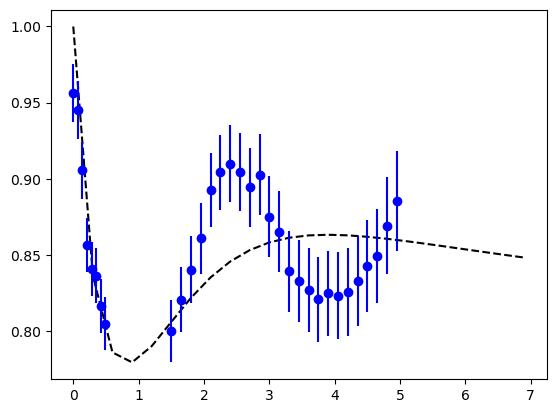

In [80]:
data = make_non_lin(true_nodes)
data_err = @.((0.02 * data) + (0.003 * data_x))

N = length(data_err) 
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

plt.plot(gp_x, make_non_lin(make_mean(gp_x)), "k--")
plt.errorbar(data_x, data, yerr=data_err, fmt="bo");

### 2. Check what our priors look like

In [167]:
function model_latent_GP(eta, l, v;  
                         X=gp_x, data_x=data_x, data_cov=data_cov)
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(X; eta=eta, l=l)
    mean = make_mean(X)
    gp = latent_GP(mean, v, kernel)
    y =  conditional(X, data_x, gp, sqexp_cov_fn;
                     eta=eta, l=l)
    non_lin_y = make_non_lin(y)
    return gp, y, non_lin_y
end

model_latent_GP (generic function with 1 method)

In [83]:
N_samples = 100
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
non_lin_ys=zeros(N_samples, 32)
for i in 1:N_samples
    eta = rand(Uniform(0., 0.1))
    l = rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(length(gp_x)), ones(length(gp_x))))
    gps[i, :], ys[i, :], non_lin_ys[i,:] = model_latent_GP(eta, l, v)
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
non_lin_y_m, non_lin_y_s = mean(non_lin_ys, dims=1), std(non_lin_ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

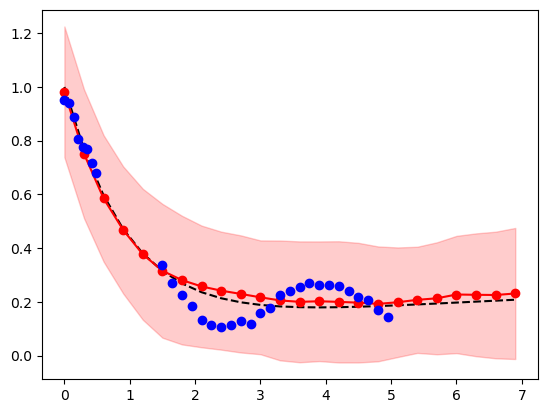

In [84]:
plt.errorbar(data_x, true_nodes, fmt="bo", label="Data")
plt.plot(gp_x, make_mean(gp_x), "k--", label="LCDM")
plt.plot(gp_x, vec(gp_m), "ro-")
plt.fill_between(gp_x, vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red");

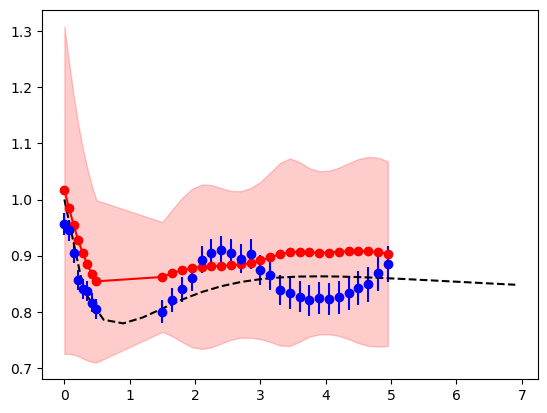

In [85]:
plt.errorbar(data_x, data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, make_non_lin(make_mean(gp_x)), "k--", label="LCDM")
plt.plot(data_x, vec(non_lin_y_m), "ro-")
plt.fill_between(data_x, vec(non_lin_y_m .+ non_lin_y_s),
                 vec(non_lin_y_m .- non_lin_y_s), alpha=0.2, color="red")
#plt.xlim(-0.1, 5.1)
#plt.ylim(-0.5, 1.7);

### 3. Define our statistical model

In [29]:
@model function stats_model(y; X=gp_x, data_x=data_x, data_cov=data_cov)
    # Priors.
    eta ~ Uniform(0.0, 0.1)
    l ~ Uniform(0.1, 3)
    v ~ MvNormal(zeros(length(X)), ones(length(X)))
    kernel = sqexp_cov_fn(X, eta=eta, l=l)
    mean = make_mean(X)
    gp = latent_GP(mean, v, kernel)
    m = conditional(X, data_x, gp, sqexp_cov_fn; eta=eta, l=l)
    y ~ MvNormal(make_non_lin(m), data_cov)
end

stats_model (generic function with 3 methods)

### 4. Sample the model

In [30]:
chain = sample(stats_model(data), NUTS(100, 0.65), 500)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/jaime/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:44


Chains MCMC chain (500×38×1 Array{Float64, 3}):

Iterations        = 101:1:600
Number of chains  = 1
Samples per chain = 500
Wall duration     = 168.72 seconds
Compute duration  = 168.72 seconds
parameters        = eta, l, v[1], v[2], v[3], v[4], v[5], v[6], v[7], v[8], v[9], v[10], v[11], v[12], v[13], v[14], v[15], v[16], v[17], v[18], v[19], v[20], v[21], v[22], v[23], v[24]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

         eta    0.0866    0.0105     0.0005    0.0005   420.4113    0.9981     ⋯
           l    0.5418    0.1964     0.0088    0.0097   203.8525    1.0075     ⋯
        v[1]   -3.2966    0.2338     0.0105    0.0110   471.1436    0.

### 5. Check how our posteriors look like

In [168]:
eta_p = group(chain, :eta).value.data[:, :, 1]
l_p = group(chain, :l).value.data[:, :, 1]
v_p = group(chain, :v).value.data[:, :, 1];

In [170]:
N_samples = length(eta_p)
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 100)
non_lin_ys=zeros(N_samples, 100)
for i in 1:N_samples
    gps[i, :], ys[i, :], non_lin_ys[i, :] = model_latent_GP(eta_p[i], l_p[i], v_p[i, :];
                                                            data_x=LinRange(0, 7, 100))
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
non_lin_y_m, non_lin_y_s = mean(non_lin_ys, dims=1), std(non_lin_ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

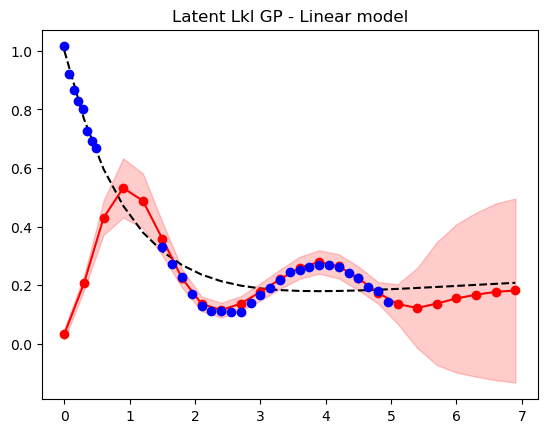

In [171]:
plt.errorbar(data_x, true_nodes, fmt="bo", label="Data")
plt.plot(gp_x, make_mean(gp_x), "k--", label="LCDM")
plt.plot(gp_x, vec(gp_m), "ro-")
plt.fill_between(gp_x, vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red");
plt.title("Latent Lkl GP - Linear model");

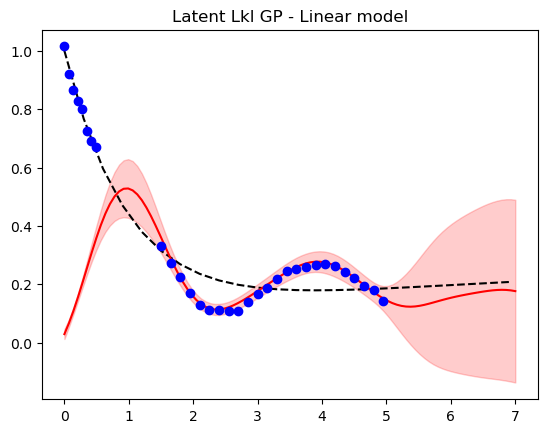

In [173]:
plt.errorbar(data_x, true_nodes, fmt="bo", label="Data")
plt.plot(gp_x, make_mean(gp_x), "k--", label="LCDM")
plt.plot(LinRange(0, 7, 100), vec(y_m), "r-")
plt.fill_between(LinRange(0, 7, 100), vec(y_m .+ y_s),  vec(y_m .- y_s), alpha=0.2, color="red");
plt.title("Latent Lkl GP - Linear model");

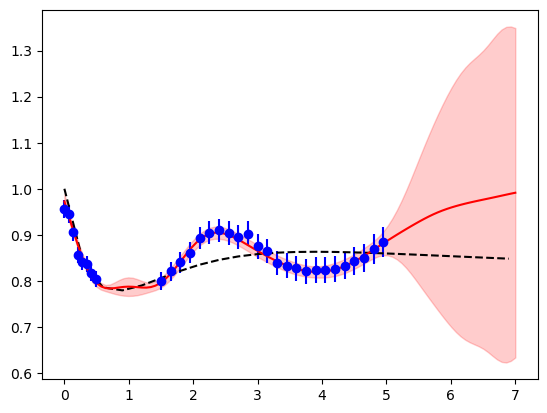

In [176]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(gp_x), make_non_lin(make_mean(gp_x)), "k--", label="LCDM")
plt.plot(LinRange(0, 7, 100), vec(non_lin_y_m), "r-")
plt.fill_between(LinRange(0, 7, 100), vec(non_lin_y_m .+ non_lin_y_s),
                 vec(non_lin_y_m .- non_lin_y_s), alpha=0.2, color="red");

### 6. GP gradients

In [181]:
function _turn_into_mat(X)
    N = length(X)
    X_mat = zeros(N, 1)
    X_mat[:,1] = X
    return X_mat
end

function ssqexp_cov_grad(X; delta=0.0005, kwargs...)
    X_mat = _turn_into_mat(X)
    D = pairwise(Distances.Euclidean(), X_mat, dims=1)
    dK = @.((1/kwargs[:l]) - (D/kwargs[:l])^2)
    return @.(dK * kwargs[:eta] * exp(-D^2 / (2*kwargs[:l]))) + delta * I
end 

ssqexp_cov_grad (generic function with 1 method)

In [182]:
function make_mean_grad(X)
    return @.(-exp(-X) + 0.1/(1+X))
end

function model_GP_grad(eta, l, v; 
                       X=gp_x, data_x=data_x, data_cov=data_cov)
    # Dimensions of predictors .
    kernel = ssqexp_cov_grad(X; eta=eta, l=l)
    mean = make_mean_grad(X)
    gp = latent_GP(mean, v, kernel)
    y =  conditional(X, data_x, gp, ssqexp_cov_grad;
                     eta=eta, l=l)
    non_lin_y = make_non_lin(y)
    return gp, y, non_lin_y
end

model_GP_grad (generic function with 1 method)

In [198]:
using Interpolations
x = LinRange(0, 7, 100)
y_fin_difs = (vec(y_m)[2:end].-vec(y_m)[1:end-1])./(x[2]-x[1])
x_mid = 0.5 .* (x[1:end-1] .+ x[2:end])
y_fin_diff = linear_interpolation(x_mid, y_fin_difs, extrapolation_bc=Line());

In [199]:
N_samples = length(eta_p)
grad_gps=zeros(N_samples, 24)
grad_ys=zeros(N_samples, 100)
grad_non_lin_ys=zeros(N_samples, 100)
for i in 1:N_samples
    grad_gps[i, :], grad_ys[i, :], grad_non_lin_ys[i, :] = model_GP_grad(eta_p[i], l_p[i], v_p[i, :];
                                                                         data_x=LinRange(0, 7, 100))
end

grad_y_m, grad_y_s = mean(grad_ys, dims=1), std(grad_ys, dims=1);
grad_non_lin_y_m, grad_non_lin_y_s = mean(grad_non_lin_ys, dims=1), std(grad_non_lin_ys, dims=1);
grad_gp_m, grad_gp_s = mean(grad_gps, dims=1), std(grad_gps, dims=1);

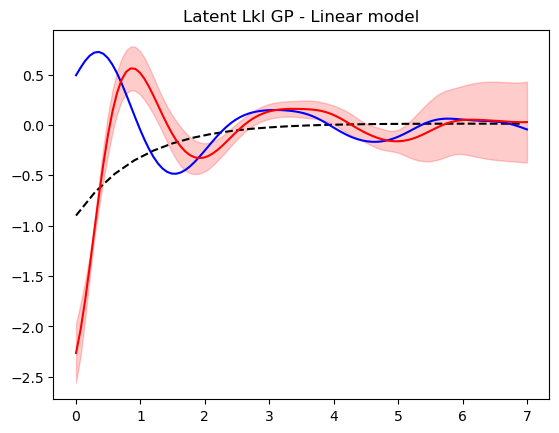

In [201]:
#plt.errorbar(data_x, true_nodes, fmt="bo", label="Data")
plt.plot(gp_x, make_mean_grad(gp_x), "k--", label="LCDM")
plt.plot(LinRange(0, 7, 100), y_fin_diff(LinRange(0, 7, 100)), "b-")
plt.plot(LinRange(0, 7, 100), vec(grad_y_m), "r-")
plt.fill_between(LinRange(0, 7, 100), vec(grad_y_m .+ grad_y_s),
                 vec(grad_y_m .- grad_y_s), alpha=0.2, color="red");
plt.title("Latent Lkl GP - Linear model");